# Visualise Angles in Videos

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

Notebook used to visualise selected angles and coordinates in videos to spot trends for heuristic model.

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Draw Angles](#1.-Draw-Angles-&-Display)

# Import Libraries & Setup

In [1]:
import cv2
import mediapipe as mp
import numpy as np
# from math import acos, degrees
import os
# import copy
import math

from IPython.display import clear_output

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def get_angle(x1, y1, x2, y2, x3, y3):
    a = np.array([x1, y1]) # First
    b = np.array([x2, y2]) # Mid
    c = np.array([x3, y3]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# 1. Draw Angles & Display

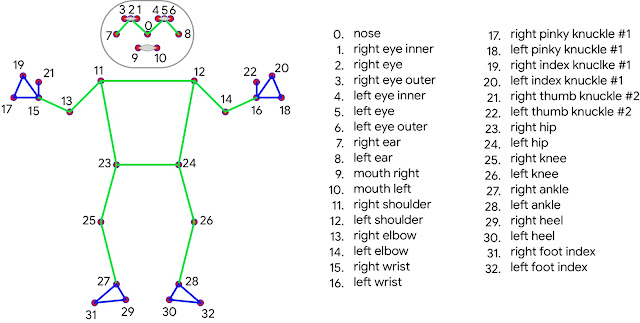

In [4]:
# The colours to display the angles we want to visualise
colours = []
colours.append((128, 0, 250)) # Pink
colours.append((255,255,0)) # Blue

angles = []
# Tuples (keypoint_1, keypoint_2, keypoint_3) that we want to visualise
# angles.append((13, 11, 23))
# angles.append((23, 25, 27))
angles.append((7, 11, 23))

if len(angles) > len(colours):
    raise ValueError('The colours array should be longer or the same length as the angles array. Please add some more colours')

In [5]:
exit = False

dir_name = 'all-vids/overhead-press-videos/knees'
dir_name = 'all-vids/overhead-press-videos/forward'
dir_name = 'all-vids/overhead-press-videos/good'
dir_name = 'all-vids/overhead-press-videos/back'

directory = os.fsencode(dir_name)

max_hip = 0
max_shoulder = 360

for file in os.listdir(directory):
    frame_count = 1
    filename = os.fsdecode(file)
    cap = cv2.VideoCapture(dir_name + '/' + filename)
#     cap = cv2.VideoCapture(0)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:
        while True:
            ret, frame = cap.read()
            if ret == False:
                break
                
            height, width, _ = frame.shape
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)
            
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            if results.pose_landmarks is not None:     
                output = None
                
                for i in range(len(angles)):
                    a = angles[i]
                    x1 = int(results.pose_landmarks.landmark[a[0]].x * width)
                    y1 = int(results.pose_landmarks.landmark[a[0]].y * height)

                    x2 = int(results.pose_landmarks.landmark[a[1]].x * width)
                    y2 = int(results.pose_landmarks.landmark[a[1]].y * height)

                    x3 = int(results.pose_landmarks.landmark[a[2]].x * width)
                    y3 = int(results.pose_landmarks.landmark[a[2]].y * height)
                
                    angle = get_angle(x1, y1, x2, y2, x3, y3)
                    
                    aux_image = np.zeros(frame.shape, np.uint8)
                    cv2.line(aux_image, (x1, y1), (x2, y2), (255, 255, 0), 20)
                    cv2.line(aux_image, (x2, y2), (x3, y3), (255, 255, 0), 20)
                    cv2.line(aux_image, (x1, y1), (x3, y3), (255, 255, 0), 5)
                    contours = np.array([[x1, y1], [x2, y2], [x3, y3]])
                    cv2.fillPoly(aux_image, pts=[contours], color=colours[i])
                    
                    # Stack frames on top of each other
                    if i==0:
                        output = cv2.addWeighted(frame, 1, aux_image, 0.8, 0)
                    else:
                        output = cv2.addWeighted(output, 1, aux_image, 0.8, 0)

                    cv2.circle(output, (x1, y1), 6, (0, 255, 255), 4)
                    cv2.circle(output, (x2, y2), 6, (128, 0, 250), 4)
                    cv2.circle(output, (x3, y3), 6, (255, 191, 0), 4)
                    cv2.putText(output, str(int(angle)), (x2 + 30, y2), 1, 1.5, colours[i], 2)
                    
                cv2.rectangle(output, (0, 0), (900, 60), (0, 0, 0), -1)
                cv2.putText(output, 'shoulder angle is ' + str(round(angle,1)), 
                        (0,40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                cv2.imshow("output", output)

#                 clear_output(wait=True)
            
#                 print('shoulder angle is ', angle_2)
#                 print('elbow hip angle is ', angle_3)
                
#                 max_shoulder = min(max_shoulder, angle_2)
#                 max_hip = max(max_hip, angle_3)
                
#                 print('min shoulder so far is ', max_shoulder)
#                 print('max elbow hip so far is ', max_hip)

            if cv2.waitKey(1) & 0xFF == 27:
                exit = True
                break

    cap.release()
    cv2.destroyAllWindows()
    
    if exit == True:
        break

FileNotFoundError: [WinError 3] The system cannot find the path specified: b'all-vids/bicep-curl-videos/elbow'